In [1]:
import cv2
import inspect
from keras import Sequential, applications
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
import matplotlib.pyplot as plt
import random
from timeit import default_timer as timer
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- 데이터 탐색

In [3]:
train_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Train'
validation_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Validation'
test_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Test'
train_withmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Train/WithMask'
train_withoutmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Train/WithoutMask'
test_withmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Test/WithMask'
test_withoutmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Test/WithoutMask'
validation_withmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Validation/WithMask'
validation_withoutmask_dir = '/content/drive/MyDrive/archive/Face_Mask_Dataset/Validation/WithoutMask'

In [4]:
# 파일 이름
import os 
train_withmask_fnames = os.listdir(train_withmask_dir)
train_withoutmask_fnames = os.listdir(train_withoutmask_dir)

test_withmask_fnames = os.listdir(test_withmask_dir)
test_withoutmask_fnames = os.listdir(test_withoutmask_dir)
print(train_withmask_fnames[:5])
print(train_withoutmask_fnames[:5])

['Augmented_874_7619194.png', 'Augmented_9_1375517.png', 'Augmented_806_2154764.png', 'Augmented_886_9719163.png', 'Augmented_97_4059957.png']
['5486.png', '5247.png', '4893.png', '5375.png', '4898.png']


In [5]:
# 파일 갯수 
len(train_withmask_fnames), len(train_withoutmask_fnames)

(5000, 5000)

In [6]:
len(test_withmask_fnames), len(test_withoutmask_fnames)

(483, 509)

- 이미지 확인

In [7]:
import cv2
from PIL import Image



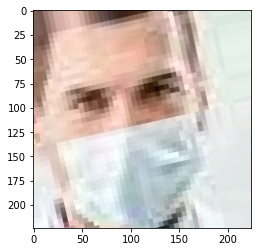

In [8]:
fname = os.path.join(train_withmask_dir, 'Augmented_157_5707542.png')
img = Image.open(fname)
plt.imshow(img)

- 마스크 쓴 이미지, 안 쓴 이미지 각각 4개씩 도출


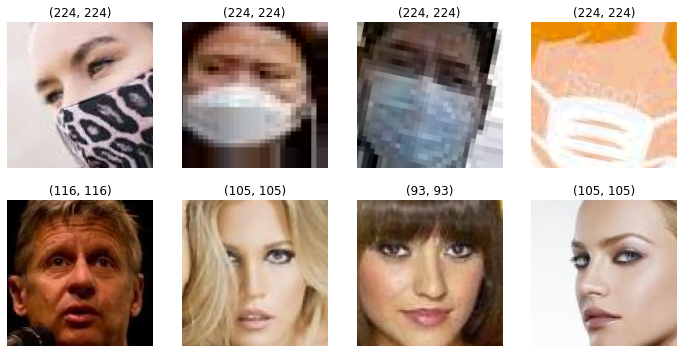

In [9]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2,4, i + 1)
    withmask = cv2.imread(os.path.join(train_withmask_dir, train_withmask_fnames[i]))[:,:,::-1]
    plt.imshow(withmask), plt.axis('off'), plt.title(withmask.shape[:-1])
    
    plt.subplot(2,4 ,i + 5)
    withoutmask = cv2.imread(os.path.join(train_withoutmask_dir, train_withoutmask_fnames[i]))[:,:,::-1]
    plt.imshow(withoutmask), plt.axis('off'), plt.title(withoutmask.shape[:-1])

Data Augmentation
- 훈련 데이터의 과적합을 방지하기 위해 데이터 부풀리기 적용
- 이를 위해서 image Data Generator를 사용 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255., # 255개의 RGB values에 맞춰서 축소
    rotation_range=15, # 기울어진 얼굴
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8, 2.0], # 확대된 얼굴
    horizontal_flip=True, # 좌우 반전된 얼굴
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255) # validation

In [11]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

img = load_img('/content/drive/MyDrive/archive/Face_Mask_Dataset/Train/WithMask/1008.png')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x.shape

(1, 116, 116, 3)

In [12]:
train_data_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Face_Mask_Dataset/Train',
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)


Found 10000 images belonging to 2 classes.


In [13]:
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/archive/Face_Mask_Dataset/Test',
    target_size=(224,224),
    batch_size=20,
    class_mode='binary'
)

Found 992 images belonging to 2 classes.


- 데이터 가공 전 모델 정확도 예측

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
model = Sequential([
                    Conv2D(16, kernel_size =(3,3), input_shape =(224,224,3), activation= 'relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Conv2D(32, (3,3), activation= 'relu'),
                    MaxPooling2D(), 
                    Dropout(0.25),
                    Conv2D(64, (3,3), activation= 'relu'),
                    MaxPooling2D(),
                    Dropout(0.25),
                    Flatten(), 
                    Dense(32, activation= 'relu'),
                    Dropout(0.5),
                    Dense(1, activation= 'sigmoid'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 54, 54, 32)        0

In [19]:
model.compile(
    optimizer= 'adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

- Callback 정의

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-face_mask-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=5)

In [21]:
hist = model.fit(
    train_data_generator,   # 훈련데이터셋을 제공할 제네레이터
    steps_per_epoch=500,     
    epochs=20, verbose=1,
    validation_data=test_data_generator,    # 검증데이터셋을 제공할 제네레이터
    validation_steps=100,      # 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
    callbacks=[checkpoint, early_stop]
)

Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.8999WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 100 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.13623, saving model to best-face_mask-v3.h5
500/500 [==============================] - 1251s 3s/step - loss: 0.2371 - accuracy: 0.8999 - val_loss: 0.1362 - val_accuracy: 0.9496
Epoch 2/20
500/500 [==============================] - 133s 266ms/step - loss: 0.2061 - accuracy: 0.9195
Epoch 3/20
500/500 [==============================] - 132s 264ms/step - loss: 0.1825 - accuracy: 0.9374
Epoch 4/20
500/500 [==============================] - 133s 265ms/step - loss: 0.1697 - accuracy: 0.9412
Epoch 5/20
500/500 [==============================] - 132s 264ms/step - loss: 0.1634 - accuracy: 0.9421

In [22]:
model.evaluate(test_data_generator, steps=5)

5/5 [==============================] - 0s 60ms/step - loss: 0.0965 - accuracy: 0.9700


[0.09646698087453842, 0.9700000286102295]